## Classificando Meteoros

Esse script utiliza deep learning para classificar imagens do céu noturno como contendo meteoros e ausente de meteoros. Utilizaremos uma CNN pré treinada no imagenet, com arquitetura resnet 34. A base de dados contém 47 imagens de meteoros e 81 imagens de outros objetos não identificados. As imagens foram capturadas por um software que detecta objetos no céu noturno. O validation set consiste em 30% do total de imagens.

## Inicialização

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

PATH = "Data/DadosMeteorosLorena/"
sz=224 #Tamanho para o qual as imagens serao convertidas

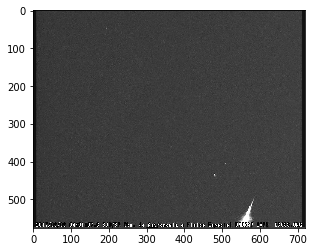

In [2]:
exemplo = os.listdir(f'{PATH}valid/Meteoros')[0]
img = plt.imread(f'{PATH}valid/Meteoros/{exemplo}')
plt.imshow(img);

Exemplo de meteoro

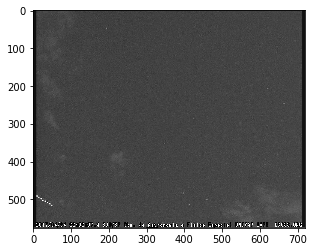

In [3]:
exemplo = os.listdir(f'{PATH}valid/NotMeteoros')[0]
img = plt.imread(f'{PATH}valid/NotMeteoros/{exemplo}')
plt.imshow(img);

Exemplo de objeto diferente de meteoro

## Treinando o modelo

In [55]:
arch=resnet34

Procurando uma learning rate:

In [62]:
data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms_from_model(arch, sz)) #reduzindo o batch size para a busca de 
                                                                                            #learning rates
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find() #buscando learning rates

 63%|██████▎   | 29/46 [00:00<00:00, 228.07it/s, loss=11]   


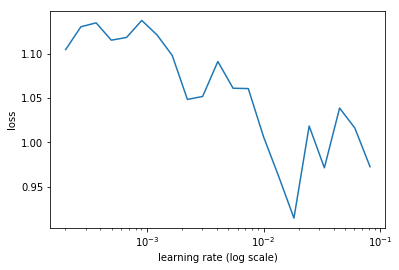

In [63]:
learn.sched.plot()

Escolhemos 0.01 como a learning rate adequada

In [53]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5) 

epoch      trn_loss   val_loss   accuracy       
    0      0.919732   0.714191   0.621622  
    1      0.859332   0.598541   0.621622        
    2      0.72355    0.482908   0.648649        
    3      0.635738   0.410333   0.810811        
    4      0.578686   0.378291   0.837838        



[array([0.37829]), 0.837837815284729]

Podemos constatar que o modelo é capaz de generalização, porque o erro do validation set é menor do que o do training set. Em nossos testes, atingimos precisão máxima com 5 epochs de treinamento.

# Analisando as predições

In [5]:
# Podemos ver que a classe 0 é Meteoros, e a classe 1 NotMeteoros
data.classes

['Meteoros', 'NotMeteoros']

In [6]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [7]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 3, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [8]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [9]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [10]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [11]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Meteoros


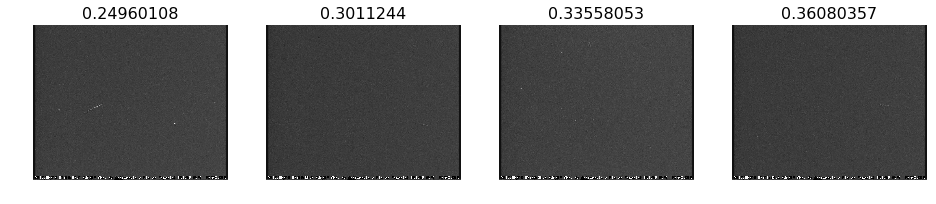

In [12]:
plot_val_with_title(most_by_correct(0, True), "Most correct Meteoros")

Most correct Not Meteoros


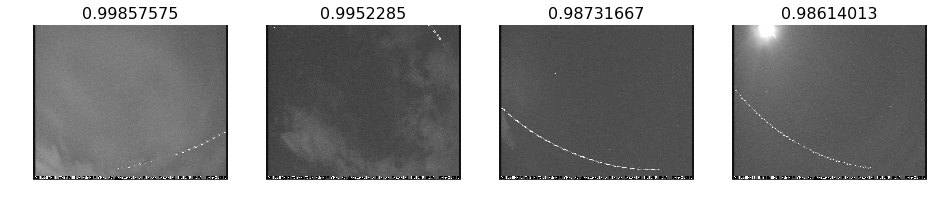

In [13]:
plot_val_with_title(most_by_correct(1, True), "Most correct Not Meteoros")

Podemos ver uma baixa confiança quando se trata da presença de meteoros, quando comparada a certeza de que é um objeto diferente de um meteoro

Most incorrect Meteoros


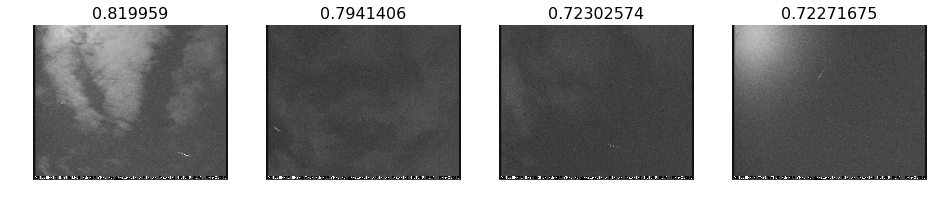

In [14]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Meteoros")

É preocupante a confiança com a qual o modelo julga que não há meteoros nessas imagens.

In [15]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Not Meteoros")

Most incorrect Not Meteoros


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


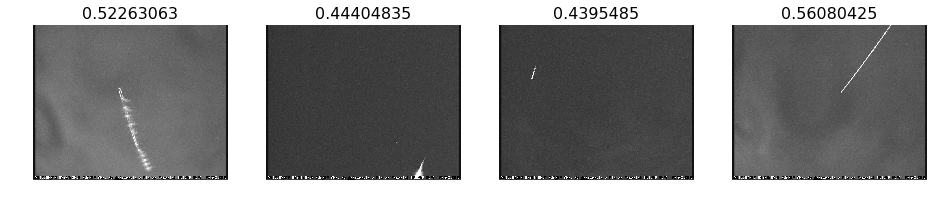

In [17]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

[[10  4]                             
 [ 2 21]]


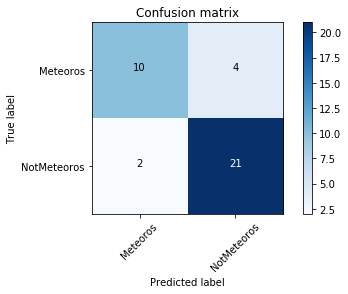

In [54]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)     
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)